# Stock Analysis project
## Data gathering
The data was gathered from the Bovespa website in the historical quotes [link](http://www.bmfbovespa.com.br/pt_br/servicos/market-data/historico/mercado-a-vista/cotacoes-historicas/). The instructions to interpret the data are in the same website.

In [1]:
%matplotlib inline

# All imports
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

# Constants
RANDOM_SEED = 42
DAYS_AHEAD = 1 - 1  #DAYS_AHEAD = 0 is looking 1 day ahead, trying to know today with the data from the past
GAIN_IN_TRAIN = 0.01 #The higher the number lower the number of trades but higher the certainty on it (in theory)

# Data gathering
stocks = ['ITSA4 ']#,'PETR4 ','VALE5 '] # Algorithm still need to remove 50 first days of stocks when using more than one.
paths = ['stock_price\\inputs\\COTAHIST_A2006.TXT','stock_price\\inputs\\COTAHIST_A2007.TXT',
        'stock_price\\inputs\\COTAHIST_A2008.TXT','stock_price\\inputs\\COTAHIST_A2009.TXT',
        'stock_price\\inputs\\COTAHIST_A2010.TXT','stock_price\\inputs\\COTAHIST_A2011.TXT',
        'stock_price\\inputs\\COTAHIST_A2012.TXT','stock_price\\inputs\\COTAHIST_A2013.TXT',
        'stock_price\\inputs\\COTAHIST_A2014.TXT','stock_price\\inputs\\COTAHIST_A2015.TXT']
df = pd.DataFrame()
for stock in stocks:
    for path in paths:
        file = open(path,'r')
        for line in file:
            if (line[12:18] == stock):
                df = df.append({'year': int(line[2:6]),'month': int(line[6:8]),'day': int(line[8:10]),
                                'open': int(line[56:69])/100.,'high': int(line[69:82])/100.,
                                'low': int(line[82:95])/100.,'close': int(line[108:121])/100.,
                                'volume': int(line[152:170]), 'stock': stocks.index(stock)},ignore_index=True)
        file.close
df.describe()

,close,day,high,low,month,open,stock,volume,year
count,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.0,2.470000e+03,2470.000000
mean,10.052960,15.768421,10.186356,9.895947,6.501619,10.051919,0.0,9.869202e+06,2010.503644
std,1.558419,8.754459,1.557275,1.551361,3.413070,1.558657,0.0,6.455192e+06,2.870181
min,5.040000,1.000000,5.240000,4.820000,1.000000,5.000000,0.0,8.920000e+05,2006.000000
25%,8.890000,8.000000,9.020000,8.760000,4.000000,8.902500,0.0,5.397350e+06,2008.000000
50%,9.840000,16.000000,9.980000,9.690000,7.000000,9.830000,0.0,8.430600e+06,2011.000000
75%,11.327500,23.000000,11.495000,11.147500,9.000000,11.347500,0.0,1.256762e+07,2013.000000
max,13.990000,31.000000,14.060000,13.830000,12.000000,14.050000,0.0,7.177790e+07,2015.000000


## Technical analysis
The main data has already been gathered. Now it is time to use what is called technical analysis to improve the data we already have.

The technical analysis consideres that the price movement of a stock reflects every thing that you need to know about the stock. The following image shows the analysis of a technical analist:

![Analysis of a technical analist](http://www.liberatedstocktrader.com/wp-content/uploads/stock-market-analysis-sept-20-2010.jpg)

To perform this analysis there is some indicators (calculated from the prizes) that are used for the behaviour prediction. We will use [Moving Averages](http://www.investopedia.com/terms/m/movingaverage.asp) for 5, 8, 21 and 50 periods.

It is important to notice that we will only have the data for previous periods and not from our period. So to start we will make every date know about its 50 previous closing prices

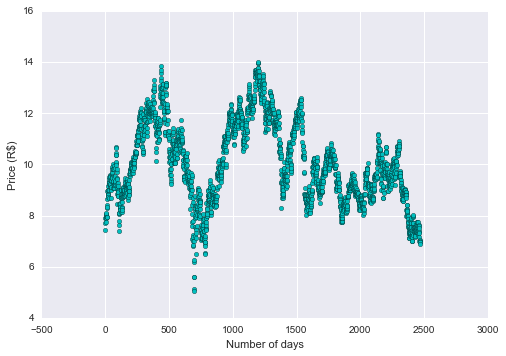

In [2]:
plt.scatter(df.index.tolist(),df['close'].values,c='c')
plt.xlabel('Number of days')
plt.ylabel('Price (R$)')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:31<00:00,  3.04s/it]


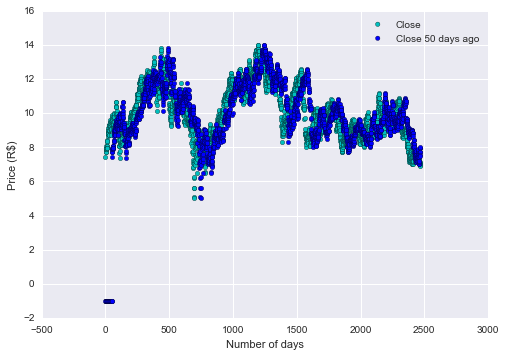

In [3]:
# Knowing the past
for i in tqdm(range(1,50 + 1)):
    for moment in ('close','low','high','open'):
        df[moment+str(i)] = -1
        for j in range(50,len(df)):
            df.loc[j,moment+str(i)] = df.loc[j-i,moment]

# Verify if the code worked
close = plt.scatter(df.index.tolist(),df['close'].values,c='c')
close50 = plt.scatter(df.index.tolist(),df['close50'].values)
plt.legend((close,close50),('Close','Close 50 days ago'))
plt.xlabel('Number of days')
plt.ylabel('Price (R$)')
plt.show()

### Creating Moving averages

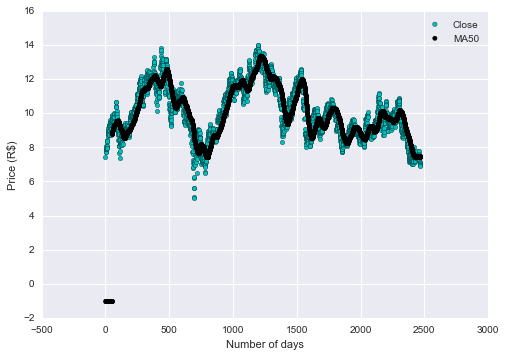

In [7]:
for i in (5,8,21,50):
    df['MA'+str(i)] = -1
    for j in range(50,len(df)):
        sum = 0
        for k in range(1,i+1):
            sum += df.loc[j,'close'+str(k)]
        df.loc[j,'MA'+str(i)] = sum/i

# Verify if the code worked
close = plt.scatter(df.index.tolist(),df['close'].values,c='c')
ma50 = plt.scatter(df.index.tolist(),df['MA50'].values,c='k')
plt.legend((close,ma50),('Close','MA50'))
plt.xlabel('Number of days')
plt.ylabel('Price (R$)')
plt.show()

### Creating RSI

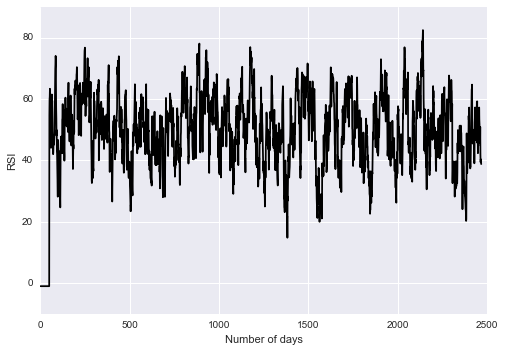

In [5]:
for i in (2,5,7,14):
    df['RSI'+str(i)] = -1
    df['AvgGain'+str(i)] = -1
    df['AvgLoss'+str(i)] = -1
    for j in range(50,51):
        sum_gain = 0
        sum_loss = 0
        for k in range(1,i+1):
            change = df.loc[j,'close'+str(k)] - df.loc[j,'close'+str(k+1)]
            if change > 0:
                sum_gain += change
            else:
                sum_loss -= change
        df.loc[j,'AvgGain'+str(i)] = sum_gain/i
        df.loc[j,'AvgLoss'+str(i)] = sum_loss/i
        df.loc[j,'RSI'+str(i)] = (100 - 100/(1+(df.loc[j,'AvgGain'+str(i)]/df.loc[j,'AvgLoss'+str(i)])) if df.loc[j,'AvgLoss'+str(i)] != 0 else 0)
    for j in range(51,len(df)):
        sum_gain = 0
        sum_loss = 0
        change = df.loc[j,'close1'] - df.loc[j,'close2']
        if change > 0:
            sum_gain += change
        else:
            sum_loss -= change
        df.loc[j,'AvgGain'+str(i)] = (df.loc[j-1,'AvgGain'+str(i)]*(i-1) + sum_gain)/i
        df.loc[j,'AvgLoss'+str(i)] = (df.loc[j-1,'AvgLoss'+str(i)]*(i-1) + sum_loss)/i
        df.loc[j,'RSI'+str(i)] = (100 - 100/(1+(df.loc[j,'AvgGain'+str(i)]/df.loc[j,'AvgLoss'+str(i)])) if df.loc[j,'AvgLoss'+str(i)] != 0 else 0)
    df = df.drop(['AvgGain'+str(i),'AvgLoss'+str(i)],1)

# Verify if the code worked
plt.plot(df.index.tolist(),df['RSI14'].values,'-',c='k')
plt.xlabel('Number of days')
plt.ylabel('RSI')
plt.show()

### Creating day of the week

We also want to know which day of the week it is. There is some studies that argue that a stock has a higher probability of moving up depending of the day of the week.

In [8]:
df['week_day']=-1
for i in range(len(df)):
    df.loc[i,'week_day'] = datetime.datetime(int(df.loc[i,'year']), int(df.loc[i,'month']), int(df.loc[i,'day'])).weekday()
# Just for information Monday to Sunday is 0 to 6

The volume that we have are also from the last days. In the case of the volume we will gather only the volume for the last 5 days.

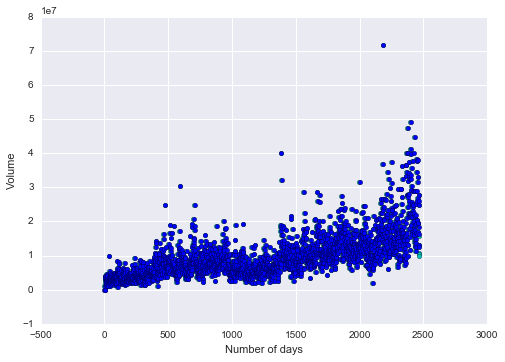

In [9]:
for i in range(1,5 + 1):
    df['volume'+str(i)] = -1
    for j in range(5,len(df)):
        df.loc[j,'volume'+str(i)] = df.loc[j-i,'volume']

# Verify if the code worked
plt.scatter(df.index.tolist(),df['volume'].values,c='c')
plt.scatter(df.index.tolist(),df['volume5'].values)
plt.xlabel('Number of days')
plt.ylabel('Volume')
plt.show()

### Check the ups in the last 5 days

In [10]:
for i in range(1,6):
    df['up'+str(i)] = df['close'+str(i)] - df['open'+str(i)]

## Preparing the data to use
Since the price of the stock varies alot, the important aspect here is the movement relative to the last price. So every price show be divided by the last price (close1) so we have the relative price of the movements until here.
We will do the same for the volumes (volume1).

In [11]:
df.loc[:,'close'] = df.loc[:,'close']/df.loc[:,'close1']
df.loc[:,'low'] = df.loc[:,'low']/df.loc[:,'close1']
df.loc[:,'high'] = df.loc[:,'high']/df.loc[:,'close1']
df.loc[:,'open'] = df.loc[:,'open']/df.loc[:,'close1']

for i in range(2,50+1):
    df.loc[:,'close'+str(i)] = df.loc[:,'close'+str(i)]/df.loc[:,'close1']
    df.loc[:,'low'+str(i)] = df.loc[:,'low'+str(i)]/df.loc[:,'close1']
    df.loc[:,'high'+str(i)] = df.loc[:,'high'+str(i)]/df.loc[:,'close1']
    df.loc[:,'open'+str(i)] = df.loc[:,'open'+str(i)]/df.loc[:,'close1']
    
for i in (5,8,21,50):
    df.loc[:, 'MA'+str(i)] = df.loc[:, 'MA'+str(i)]/df.loc[:,'close1']

for i in range(1,6):
    df.loc[:,'up'+str(i)] = df.loc[:,'up'+str(i)]/df.loc[:,'close1']
    
df.loc[:,'close1'] = df.loc[:,'close1']/df.loc[:,'close1']
df.loc[:,'low1'] = df.loc[:,'low1']/df.loc[:,'close1']
df.loc[:,'high1'] = df.loc[:,'high1']/df.loc[:,'close1']
df.loc[:,'open1'] = df.loc[:,'open1']/df.loc[:,'close1']

We will do the same for the volumes (volume1).

In [12]:
df.loc[:,'volume'] = df.loc[:,'volume']/df.loc[:,'volume1']

for i in range(2,5+1):
    df.loc[:,'volume'+str(i)] = df.loc[:,'volume'+str(i)]/df.loc[:,'volume1']
    
df.loc[:,'volume1'] = df.loc[:,'volume1']/df.loc[:,'volume1']

## Clean the data
Since the data is now read, we need to erase the 50 first days. They do not have all the indicators that we need for the analysis and it can bring some problems.

In [13]:
df = df.loc[50:].reset_index()

df.describe()

,index,close,day,high,low,month,open,stock,volume,year,...,volume1,volume2,volume3,volume4,volume5,up1,up2,up3,up4,up5
count,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.0,2420.000000,2420.000000,...,2420.0,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000
mean,1259.500000,1.000148,15.827686,1.013691,0.984216,6.598760,0.999922,0.0,1.091569,2010.596694,...,1.0,1.090639,1.112967,1.124177,1.126649,-0.000156,-0.000152,-0.000146,-0.000110,-0.000127
std,698.738148,0.023617,8.758794,0.018685,0.018869,3.378029,0.013028,0.0,0.484045,2.824945,...,0.0,0.489919,0.566877,0.600116,0.609671,0.019808,0.019846,0.019863,0.019890,0.020012
min,50.000000,0.884451,1.000000,0.915966,0.804598,1.000000,0.897292,0.0,0.148279,2006.000000,...,1.0,0.155512,0.214063,0.107376,0.177112,-0.118812,-0.123529,-0.115460,-0.117063,-0.114516
25%,654.750000,0.987614,8.000000,1.003876,0.976634,4.000000,0.994764,0.0,0.759577,2008.000000,...,1.0,0.757911,0.734696,0.725392,0.726525,-0.011222,-0.011236,-0.011259,-0.011247,-0.011236
50%,1259.500000,1.000000,16.000000,1.010712,0.986952,7.000000,1.000000,0.0,0.996591,2011.000000,...,1.0,1.003922,0.990703,0.998705,0.988535,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1864.250000,1.011497,23.000000,1.020516,0.995135,9.000000,1.005638,0.0,1.321244,2013.000000,...,1.0,1.316523,1.344790,1.357989,1.382446,0.011069,0.011114,0.011079,0.011105,0.011170
max,2469.000000,1.251471,31.000000,1.251471,1.070833,12.000000,1.131944,0.0,6.430380,2015.000000,...,1.0,6.744062,6.564526,9.389013,6.948186,0.141011,0.137931,0.153846,0.165746,0.175182


## Preparing the target
Until now we have not prepared the target, the target will be a data frame that gives 1 when price close higher than price open, otherwise it returns 1.

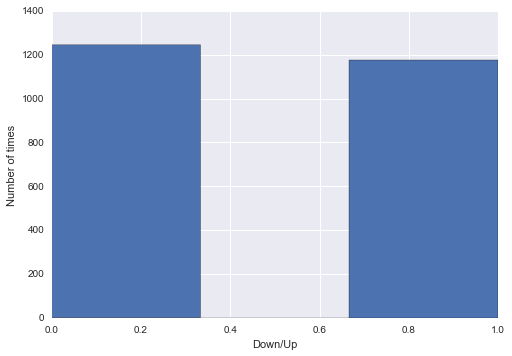

2420

In [14]:
y_all = []

for i in range(len(df)-DAYS_AHEAD):
    is_higher = (1 if (df.loc[i+DAYS_AHEAD,'close']/df.loc[i,'open'] > 1.) else 0)
    y_all.extend([is_higher])
    
df.loc[:len(df)-DAYS_AHEAD-1,'up'] = y_all
    
df = df.dropna()

plt.hist(y_all,bins=3)
plt.xlabel('Down/Up')
plt.ylabel('Number of times')
plt.show()

len(y_all)

We can see that it is almost a 50% chance for the day to close higher or not.

For future purpose we will create a y_all_narrow that returns days with a gain higher than 1%

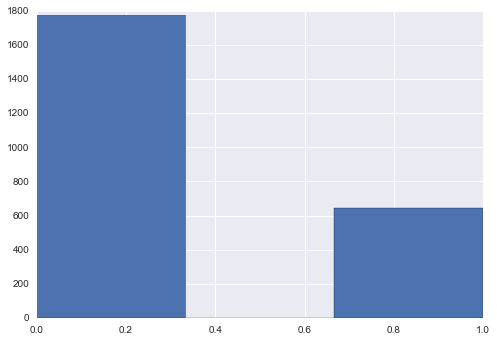

2420

In [15]:
y_all_narrow = []

for i in range(len(df)-DAYS_AHEAD):
    is_higher = (1 if (df.loc[i+DAYS_AHEAD,'close']/df.loc[i,'open'] > 1. + GAIN_IN_TRAIN) else 0)
    y_all_narrow.extend([is_higher])
    
df.loc[:len(df)-DAYS_AHEAD-1,'up_narrow'] = y_all_narrow
    
df = df.dropna()

plt.hist(y_all_narrow,bins=3)
plt.show()

len(y_all_narrow)

We can see that if we go for the y_all_narrow we are aiming to much less data than if we aim to y_all, y_all_narrow is a little bit less than 1/3 of the total data

## Prepare data
Now that we have the target we can clean our data to start the work. Removing index and data from the day, removing objective (up), removing day (since the systems can use it to overfit), removing constants (close1 and volume1).

In [16]:
X_all = df.drop(['index','close','low','high','open','volume','up','up_narrow','day','close1','volume1'],1)

for i in range(16,50+1):
    X_all = X_all.drop(['close'+str(i),'low'+str(i),'high'+str(i),'open'+str(i)],1)

X_all.describe()

,month,stock,year,low1,high1,open1,close2,low2,high2,open2,...,week_day,volume2,volume3,volume4,volume5,up1,up2,up3,up4,up5
count,2420.000000,2420.0,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,...,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000
mean,6.598760,0.0,2010.596694,9.923979,10.214463,10.080145,1.000400,0.984629,1.014140,1.000552,...,1.995868,1.090639,1.112967,1.124177,1.126649,-0.000156,-0.000152,-0.000146,-0.000110,-0.000127
std,3.378029,0.0,2.824945,1.552158,1.557883,1.559092,0.023444,0.026513,0.027531,0.031190,...,1.409816,0.489919,0.566877,0.600116,0.609671,0.019808,0.019846,0.019863,0.019890,0.020012
min,1.000000,0.0,2006.000000,4.820000,5.240000,5.000000,0.799060,0.719154,0.822562,0.746181,...,0.000000,0.155512,0.214063,0.107376,0.177112,-0.118812,-0.123529,-0.115460,-0.117063,-0.114516
25%,4.000000,0.0,2008.000000,8.787500,9.040000,8.920000,0.988634,0.971637,0.998339,0.982803,...,1.000000,0.757911,0.734696,0.725392,0.726525,-0.011222,-0.011236,-0.011259,-0.011247,-0.011236
50%,7.000000,0.0,2011.000000,9.740000,10.010000,9.880000,1.000000,0.986301,1.011818,1.000000,...,2.000000,1.003922,0.990703,0.998705,0.988535,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,0.0,2013.000000,11.172500,11.530000,11.372500,1.012458,0.999154,1.027004,1.017587,...,3.000000,1.316523,1.344790,1.357989,1.382446,0.011069,0.011114,0.011079,0.011105,0.011170
max,12.000000,0.0,2015.000000,13.830000,14.060000,14.050000,1.130645,1.111290,1.223092,1.212500,...,4.000000,6.744062,6.564526,9.389013,6.948186,0.141011,0.137931,0.153846,0.165746,0.175182


# Data analysis
Let's use the data to plot some small studies about the behaviour of the y_all.
## Day of the week

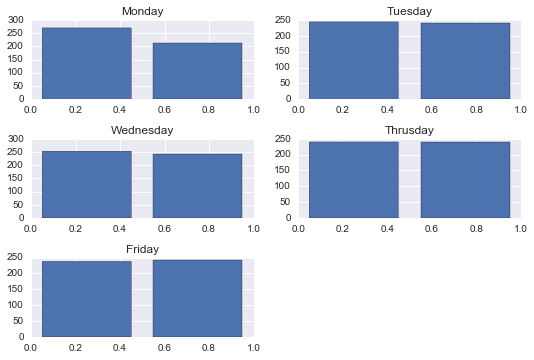

In [30]:
plt.subplot(321)
plt.hist(df[df['week_day']==0]['up'],bins=2,rwidth=0.8)
plt.title('Monday')
plt.subplot(322)
plt.hist(df[df['week_day']==1]['up'],bins=2,rwidth=0.8)
plt.title('Tuesday')
plt.subplot(323)
plt.hist(df[df['week_day']==2]['up'],bins=2,rwidth=0.8)
plt.title('Wednesday')
plt.subplot(324)
plt.hist(df[df['week_day']==3]['up'],bins=2,rwidth=0.8)
plt.title('Thrusday')
plt.subplot(325)
plt.hist(df[df['week_day']==4]['up'],bins=2,rwidth=0.8)
plt.title('Friday')
plt.subplots_adjust(left=0.09, bottom=0.10, right=0.94, top=0.90, wspace=0.2, hspace=0.5)
plt.show()

## Month of the year

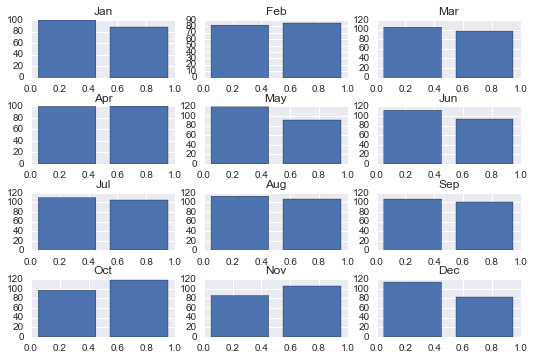

In [18]:
plt.subplot(431)
plt.hist(df[df['month']==1]['up'],bins=2,rwidth=0.8)
plt.title('Jan')
plt.subplot(432)
plt.hist(df[df['month']==2]['up'],bins=2,rwidth=0.8)
plt.title('Feb')
plt.subplot(433)
plt.hist(df[df['month']==3]['up'],bins=2,rwidth=0.8)
plt.title('Mar')
plt.subplot(434)
plt.hist(df[df['month']==4]['up'],bins=2,rwidth=0.8)
plt.title('Apr')
plt.subplot(435)
plt.hist(df[df['month']==5]['up'],bins=2,rwidth=0.8)
plt.title('May')
plt.subplot(436)
plt.hist(df[df['month']==6]['up'],bins=2,rwidth=0.8)
plt.title('Jun')
plt.subplot(437)
plt.hist(df[df['month']==7]['up'],bins=2,rwidth=0.8)
plt.title('Jul')
plt.subplot(438)
plt.hist(df[df['month']==8]['up'],bins=2,rwidth=0.8)
plt.title('Aug')
plt.subplot(439)
plt.hist(df[df['month']==9]['up'],bins=2,rwidth=0.8)
plt.title('Sep')
plt.subplot(4,3,10)
plt.hist(df[df['month']==10]['up'],bins=2,rwidth=0.8)
plt.title('Oct')
plt.subplot(4,3,11)
plt.hist(df[df['month']==11]['up'],bins=2,rwidth=0.8)
plt.title('Nov')
plt.subplot(4,3,12)
plt.hist(df[df['month']==12]['up'],bins=2,rwidth=0.8)
plt.title('Dec')
plt.subplots_adjust(left=0.09, bottom=0.10, right=0.94, top=0.90, wspace=0.2, hspace=0.5)
plt.show()

## How last 5 days closed

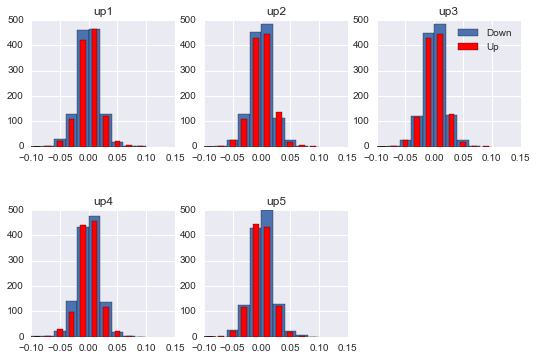

In [19]:
plt.subplot(231)
plt.hist(df[df['up']==0]['up1'],range=(-0.1,0.1),bins=10,label='Down')
plt.hist(df[df['up']==1]['up1'],range=(-0.1,0.1),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('up1')
plt.subplot(232)
plt.hist(df[df['up']==0]['up2'],range=(-0.1,0.1),bins=10,label='Down')
plt.hist(df[df['up']==1]['up2'],range=(-0.1,0.1),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('up2')
plt.subplot(233)
plt.hist(df[df['up']==0]['up3'],range=(-0.1,0.1),bins=10,label='Down')
plt.hist(df[df['up']==1]['up3'],range=(-0.1,0.1),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('up3')
plt.legend()
plt.subplot(234)
plt.hist(df[df['up']==0]['up4'],range=(-0.1,0.1),bins=10,label='Down')
plt.hist(df[df['up']==1]['up4'],range=(-0.1,0.1),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('up4')
plt.subplot(235)
plt.hist(df[df['up']==0]['up5'],range=(-0.1,0.1),bins=10,label='Down')
plt.hist(df[df['up']==1]['up5'],range=(-0.1,0.1),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('up5')
plt.subplots_adjust(left=0.09, bottom=0.10, right=0.94, top=0.90, wspace=0.2, hspace=0.5)
plt.show()

## How last volumes influence

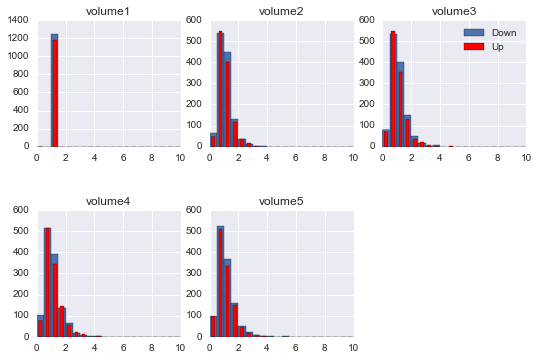

In [31]:
plt.subplot(231)
plt.hist(df[df['up']==0]['volume1'],range=(0,10),bins=20,label='Down')
plt.hist(df[df['up']==1]['volume1'],range=(0,10),bins=20,color='r',rwidth=0.5,label='Up')
plt.title('volume1')
plt.subplot(232)
plt.hist(df[df['up']==0]['volume2'],range=(0,10),bins=20,label='Down')
plt.hist(df[df['up']==1]['volume2'],range=(0,10),bins=20,color='r',rwidth=0.5,label='Up')
plt.title('volume2')
plt.subplot(233)
plt.hist(df[df['up']==0]['volume3'],range=(0,10),bins=20,label='Down')
plt.hist(df[df['up']==1]['volume3'],range=(0,10),bins=20,color='r',rwidth=0.5,label='Up')
plt.title('volume3')
plt.legend()
plt.subplot(234)
plt.hist(df[df['up']==0]['volume4'],range=(0,10),bins=20,label='Down')
plt.hist(df[df['up']==1]['volume4'],range=(0,10),bins=20,color='r',rwidth=0.5,label='Up')
plt.title('volume4')
plt.subplot(235)
plt.hist(df[df['up']==0]['volume5'],range=(0,10),bins=20,label='Down')
plt.hist(df[df['up']==1]['volume5'],range=(0,10),bins=20,color='r',rwidth=0.5,label='Up')
plt.title('volume5')
plt.subplots_adjust(left=0.09, bottom=0.10, right=0.94, top=0.90, wspace=0.2, hspace=0.5)
plt.show()

## MA's
Some graphs about the Moving Averages

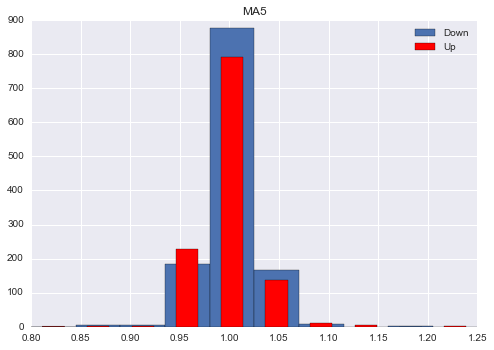

In [21]:
plt.hist(df[df['up']==0]['MA5'],range=(0.8,1.25),bins=10,label='Down')
plt.hist(df[df['up']==1]['MA5'],range=(0.8,1.25),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('MA5')
plt.legend()
plt.show()

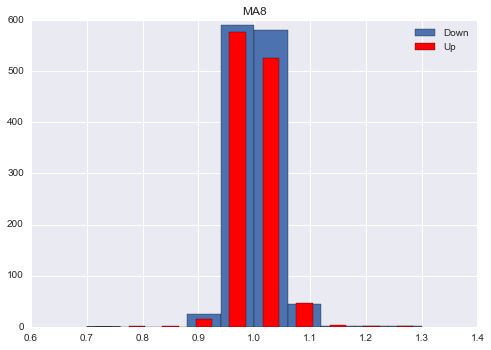

In [22]:
plt.hist(df[df['up']==0]['MA8'],range=(0.7,1.3),bins=10,label='Down')
plt.hist(df[df['up']==1]['MA8'],range=(0.7,1.3),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('MA8')
plt.legend()
plt.show()

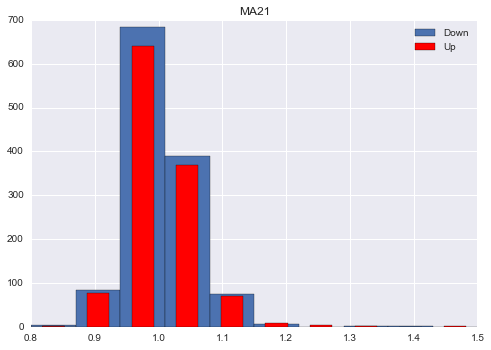

In [23]:
plt.hist(df[df['up']==0]['MA21'],range=(0.8,1.5),bins=10,label='Down')
plt.hist(df[df['up']==1]['MA21'],range=(0.8,1.5),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('MA21')
plt.legend()
plt.show()

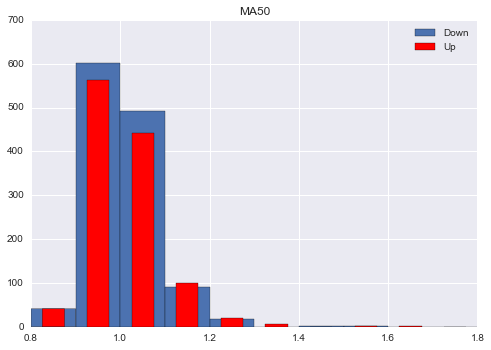

In [24]:
plt.hist(df[df['up']==0]['MA50'],range=(0.8,1.8),bins=10,label='Down')
plt.hist(df[df['up']==1]['MA50'],range=(0.8,1.8),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('MA50')
plt.legend()
plt.show()

## RSI

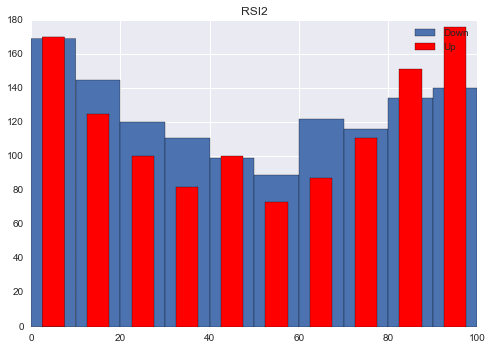

In [25]:
plt.hist(df[df['up']==0]['RSI2'],range=(0,100),bins=10,label='Down')
plt.hist(df[df['up']==1]['RSI2'],range=(0,100),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('RSI2')
plt.legend()
plt.show()

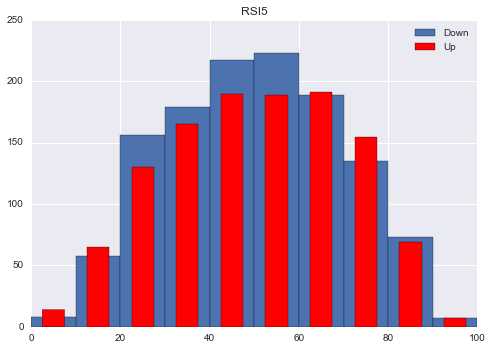

In [26]:
plt.hist(df[df['up']==0]['RSI5'],range=(0,100),bins=10,label='Down')
plt.hist(df[df['up']==1]['RSI5'],range=(0,100),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('RSI5')
plt.legend()
plt.show()

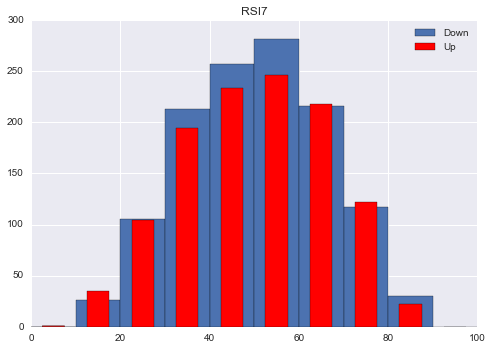

In [27]:
plt.hist(df[df['up']==0]['RSI7'],range=(0,100),bins=10,label='Down')
plt.hist(df[df['up']==1]['RSI7'],range=(0,100),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('RSI7')
plt.legend()
plt.show()

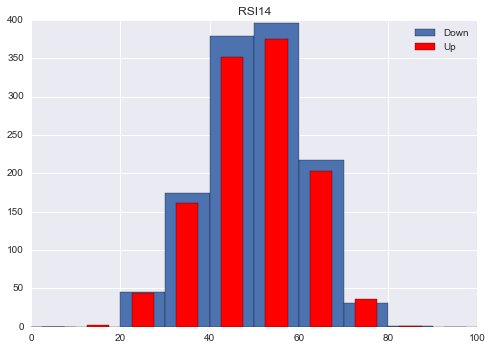

In [28]:
plt.hist(df[df['up']==0]['RSI14'],range=(0,100),bins=10,label='Down')
plt.hist(df[df['up']==1]['RSI14'],range=(0,100),bins=10,color='r',rwidth=0.5,label='Up')
plt.title('RSI14')
plt.legend()
plt.show()

# Split data
Here we are splitting the data between train and test. Since it does not look like a stratified data we are use a normal data split.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size = 0.25,
                                                    stratify = y_all_narrow, random_state = RANDOM_SEED)
X_train_narrow, X_test_narrow, y_train_narrow, y_test_narrow = train_test_split(X_all,y_all_narrow, test_size = 0.25,
                                                    stratify = y_all_narrow, random_state = RANDOM_SEED)

print("Is X_train equal:" + str(X_train.equals(X_train_narrow)))
print("Is X_test equal:" + str(X_test.equals(X_test_narrow)))

Is X_train equal:True
Is X_test equal:True


# Feature selection
We will use the PCA to evaluate the features and the sklearn.feature_selection.SelectKBest to evaluate the features considering the target values. The objective is to reduce it for a more reasonable number. In the moment we have 213 features. We will  reduce the number to components to 20.

In [ ]:
pca = PCA()

# ICA takes to long time to run, won't use it
ica = FastICA(random_state = RANDOM_SEED)

skb = SelectKBest(f_classif)
parameters_skb = {'skb__k':[30, 50, 70]}

Note: First I started with PCA and k=20 in SelectKBest, as mentioned, but the results were not good. Trying to improve I included FastICA and increased the number of variables in the SelectKBest. It improved the performance.

# Defining the classifier
Since we want to know if the stock will go up in a given day or not it is a classification problem. Considering the amount of data that we have, over 2000, we will use the Support Vector Classifier.

For the classifier decision we are using the recommendation of the sklearn website, see image below:

![sklearn map](http://scikit-learn.org/stable/_static/ml_map.png)

Together with the classifier we will implement the GridSearchCV and the makescorer.

In [ ]:
precision_scorer = make_scorer(precision_score)

In [ ]:
svc = SVC(random_state = RANDOM_SEED)

parameters_svc = {'svc__kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'svc__C':[1, 1.5, 3, 5, 10], 'svc__degree':[2,3,4]}

Since SVC is not working lets go to KNeighborsClassifier, as the map suggests.

In [ ]:
knc = KNeighborsClassifier()

parameters_knc = {'knc__n_neighbors':[2,4,5,8,16,32,64], 'knc__p':[2, 3], 'knc__leaf_size':[2,5,10,20,30]}

KNeighborsClassifier also did not work well. Let's try Decision Tree and 2 ensemble methods, AdaBoostClassifier and RandomForestClassifier.

In [ ]:
dtc = DecisionTreeClassifier(random_state = RANDOM_SEED)

parameters_dtc = {'dtc__max_depth':[5,8,15,25,30,None], 'dtc__min_samples_split':[1,2,5,10,15,100],
              'dtc__min_samples_leaf':[1,2,5,10], 'dtc__max_features':('sqrt','log2',None)}

In [ ]:
abc = AdaBoostClassifier(random_state = RANDOM_SEED)

parameters_abc = {'abc__algorithm':('SAMME','SAMME.R'), 'abc__n_estimators':[10,30,50,80,120,300,500,800,1200],
                  'abc__learning_rate':[0.1,0.5,1.0,1.5,2.0]}

In [ ]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = RANDOM_SEED)

#parameters_rfc = {'rfc__n_estimators':[10,30,50,80,120,300,500,800,1200], 'rfc__max_depth':[5,8,15,25,30,None],
#              'rfc__min_samples_split':[1,2,5,10,15,100], 'rfc__min_samples_leaf':[1,2,5,10],
#              'rfc__max_features':('sqrt','log2',None)}
parameters_rfc = {'rfc__n_estimators':[50,120,300], 'rfc__max_depth':[5,30,None], 'rfc__max_features':('sqrt','log2',None),
              'rfc__min_samples_split':[2,5,15], 'rfc__min_samples_leaf':[1,4,10]}

To run, using Pipeline

In [ ]:
possibilities = [['dtc',dtc,parameters_dtc],['knc',knc,parameters_knc],['abc',abc,parameters_abc],['rfc',rfc,parameters_rfc]]

for possibility in tqdm(possibilities):
    steps = [('skb',skb),(possibility[0], possibility[1])]
    parameters = {}
    parameters.update(parameters_skb)
    parameters.update(possibility[2])

    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, scoring = precision_scorer, verbose = 1)
    grid_search.fit(X_train, y_train_narrow)
    pipeline = grid_search.best_estimator_

    print("Tuned %s model has a training precision score of %0.4f and test score of %0.4f." % 
          (possibility[0],precision_score(y_train, pipeline.predict(X_train)),precision_score(y_test, pipeline.predict(X_test))))

In [ ]:
possibilities = [['dtc',dtc,parameters_dtc],['knc',knc,parameters_knc],['abc',abc,parameters_abc],['rfc',rfc,parameters_rfc]]

for possibility in tqdm(possibilities):
    steps = [('pca',pca),('skb',skb),(possibility[0], possibility[1])]
    parameters = {}
    parameters.update(parameters_skb)
    parameters.update(possibility[2])

    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, scoring = precision_scorer, verbose = 1)
    grid_search.fit(X_train, y_train_narrow)
    pipeline = grid_search.best_estimator_

    print("Tuned %s model has a training precision score of %0.4f and test score of %0.4f." % 
          (possibility[0],precision_score(y_train, pipeline.predict(X_train)),precision_score(y_test, pipeline.predict(X_test))))

In [ ]:
possibilities = [['dtc',dtc,parameters_dtc],['knc',knc,parameters_knc],['abc',abc,parameters_abc],['rfc',rfc,parameters_rfc]]

for possibility in tqdm(possibilities):
    steps = [('ica',ica),('skb',skb),(possibility[0], possibility[1])]
    parameters = {}
    parameters.update(parameters_skb)
    parameters.update(possibility[2])

    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, scoring = precision_scorer, verbose = 1)
    grid_search.fit(X_train, y_train_narrow)
    pipeline = grid_search.best_estimator_

    print("Tuned %s model has a training precision score of %0.4f and test score of %0.4f." % 
          (possibility[0],precision_score(y_train, pipeline.predict(X_train)),precision_score(y_test, pipeline.predict(X_test))))

Implementing the model with the best performance. The other models with good performance appears to be overfitted with very little trades.

In [ ]:
possibilities = [['dtc',dtc,parameters_dtc]]

for possibility in tqdm(possibilities):
    steps = [('skb',skb),(possibility[0], possibility[1])]
    parameters = {}
    parameters.update(parameters_skb)
    parameters.update(possibility[2])

    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, scoring = precision_scorer, verbose = 1)
    grid_search.fit(X_train, y_train_narrow)
    pipeline = grid_search.best_estimator_

    print("Tuned %s model has a training precision score of %0.4f and test score of %0.4f." % 
          (possibility[0],precision_score(y_train, pipeline.predict(X_train)),precision_score(y_test, pipeline.predict(X_test))))

In [ ]:
print("From %d days it was considering to move up %d." %
      (len(pipeline.predict(X_test)),np.count_nonzero(pipeline.predict(X_test))))

# Evaluate performance of the traders
The idea of the model is to serve as a signal for other trades. So it will give more chances for the intraday trades, for example. Anyway we will evaluate the performance of the method if we used it to buy and self stocks.

In [ ]:
indexes_buy = []

for index in X_test.index.values:
    if pipeline.predict([X_test.loc[index]]) == [1]:
        indexes_buy.append(index)
        
performance = 0.

for index in indexes_buy:
    performance += df.loc[index, 'close'] - df.loc[index, 'open']
    
print("Considering every time the model sinalized the stock would go up, we bought one share we would have a profit of %0.2f"
     % performance)